In [22]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def plot(Z):
    plt.plot(Z[:,0], Z[:, 1], 'x')
    plt.show()
    return
def generate(m, n, d, noize = 1.):
    # np.random.seed(123)
    # определяем параметры
    sigma = noize
    W = np.random.randn(n, d) * 3  + 2

    Z = np.random.normal(size = (m, d))
    eps = np.random.normal(loc = 0, scale= sigma**0.5, size = (m, n))
    X  = Z @ W.T + eps
    return X, Z, W

def Evidence(X, W, mu, sigma):
    # используется чтобы проверять сходимость алгоритма
    nn = multivariate_normal(mean = mu, cov = W @ W.T + sigma**2 * np.eye(W.shape[0])).pdf(X)
    return np.sum(np.log(nn))

def EM(X, m, n, d, max_iters = 10):
    # не знаем какие могут быть параметры, так что берем случайные
    W = np.random.rand(n, d) 
    mu = np.random.rand(n,) 
    sigma = np.random.rand() + 0.5

    B_inv = np.eye(d)
    mu_params = np.zeros(d)
    def E(X, W_s, mu_s, sigma_s):
        # пересчитываем параметры для каждого z_i
        B = (sigma_s **2 * np.eye(d) + W_s.T @ W_s) 
        B_inv = np.linalg.inv(B)
        tmp =  B_inv @ W_s.T
        mu_params =  (X - mu_s[None, :]) @ tmp.T
        return sigma_s **2 * B_inv, mu_params
    
    def M_sigma(X, B_inv, mu_params, W_s, mu_s, sigma_s):
        X_central = X - mu_s[None,:]
        WW = W_s.T @ W_s
        Wmu = mu_params @ W_s.T
        T_s = np.sum((X_central)**2) -2 * np.sum(X_central * (Wmu)) + np.sum(Wmu * Wmu) + m * np.trace(WW @ B_inv) # * m
        sigma_next = (T_s / (m * n)) ** 0.5
        return sigma_next
    def M_mu(X, B_inv, mu_params, W_s, mu_s, sigma_s):
        mu_next = np.mean(X, axis = 0) # - (mu_params) @ W_s.T, axis= 0)
        return mu_next
    def M_W(X, B_inv, mu_params, W_s, mu_s, sigma_s):
        X_central = X - mu_s[None,:]
        W_next = ( 1./m * np.sum(X_central[i][:, None] @ mu_params[i][None,:] for i in range(m))) @ np.linalg.inv(B_inv + 1./m * np.sum(mu_params[i][:, None] @ mu_params[i][None,:] for i in range(m)))
        return W_next

    evidences = []
    for i in range(max_iters):
        B_inv, mu_params = E(X, W, mu, sigma)
        evidences.append(Evidence(X, W, mu, sigma))
        sigma = M_sigma(X, B_inv, mu_params, W, mu, sigma)

        evidences.append(Evidence(X, W, mu, sigma))

        B_inv, mu_params = E(X, W, mu, sigma)
        evidences.append(Evidence(X, W, mu, sigma))
        mu = M_mu(X, B_inv, mu_params, W, mu, sigma)

        evidences.append(Evidence(X, W, mu, sigma))
        
        B_inv, mu_params = E(X, W, mu, sigma)
        evidences.append(Evidence(X, W, mu, sigma))
        W = M_W(X, B_inv, mu_params, W, mu, sigma)
        evidences.append(Evidence(X, W, mu, sigma))

    plt.plot(evidences, '.')
    # plt.yscale('log')
    plt.ylabel("evidence")
    plt.show()
    return W, mu, sigma, evidences


/var/folders/ks/7b2rqlpx6j54hmxc16v83p980000gn/T/ipykernel_8077/4237661754.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(nn))


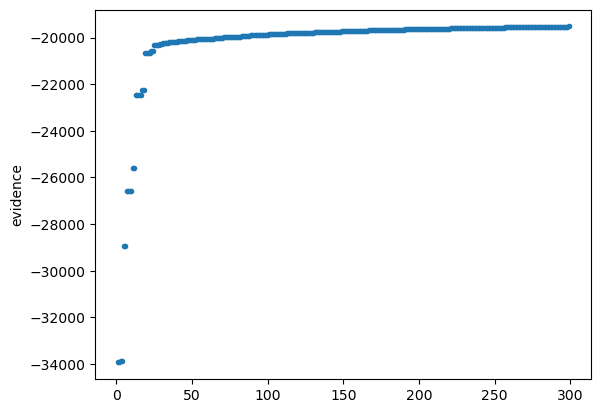

In [27]:
m = 1000
n = 10
d = 2

sigma_true = 1.
X, Z_true, W_true = generate(m, n, d, sigma_true)
W, mu, sigma, evs = EM(X, m, n, d, max_iters= 50)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 2).fit(X)
pca.components_.T, pca.mean_, pca.noise_variance_

(array([[ 0.28491868, -0.34425459],
        [-0.16863864, -0.50225888],
        [ 0.10807862,  0.47935667],
        [ 0.3337258 , -0.19132173],
        [ 0.21614271,  0.46532362],
        [ 0.77728587, -0.2056808 ],
        [ 0.17967737,  0.12288582],
        [ 0.24216976,  0.2928408 ],
        [ 0.15041163, -0.05605542],
        [-0.05369973, -0.00290458]]),
 array([ 0.06701208,  0.13257336, -0.12645118,  0.02096608, -0.14598109,
        -0.04371999, -0.01217837, -0.14084755, -0.03945642,  0.00444285]),
 1.0225980718674599)

In [28]:
print(f"evidence с правильными параметрами: {Evidence(X, W, mu, 1)}")
print(f"evidence полученный в итоге тренировки: {evs}")

evidence с правильными параметрами: -19524.561153214934
evidence полученный в итоге тренировки: -19523.282099074604


Видим, что полученный evidence такой же как у данных с исходными параметрами.

# bayessian PCA

In [56]:

def Evidence(X, W, mu, sigma):
    # используется чтобы проверять сходимость алгоритма
    nn = multivariate_normal( allow_singular= True, mean = mu, cov = W @ W.T + sigma**2 * np.eye(W.shape[0])).pdf(X)
    return np.sum(np.log(nn))

def VarEM(X, m, n, d, max_iters = 10):
    # не знаем какие могут быть параметры, так что берем случайные
    alpha = np.random.rand(d) + 1 # чтобы отделить от 0
    mu = np.random.rand(n,)
    sigma = np.random.rand()

    Z_mu = np.stack([np.random.randn(d) for i in range(m)], axis = 0)* 0.1 + 1e-2 # z_i строка. m x d 
    Z_sigma = np.eye(d)

    W_mu = np.stack([np.random.randn(n) for i in range(d)], axis=1)  # w_i - столбец n x d
    W_sigma = np.diag(alpha)

    def E_z(X, alpha_s, mu_s, sigma_s, W_mu, W_sigma):
        B = (sigma_s **2) * np.eye(d) + W_mu.T @ W_mu
        B_inv = np.linalg.inv(B)
        tmp = B_inv @ W_mu.T
        mu_params = (X - mu_s[None, :]) @ tmp.T
        return sigma_s **2  * B_inv, mu_params
    
    def E_w(X, alpha_s, mu_s, sigma_s, Z_mu, Z_sigma):
        X_central = X - mu_s[None,:]
        W_next = ( np.sum(X_central[i][:, None] @ Z_mu[i][None,:] for i in range(m))) @ np.linalg.inv(m * Z_sigma +  np.sum(Z_mu[i][:, None] @ Z_mu[i][None,:] for i in range(m)) + np.diag(alpha_s))
        return 0, W_next
    

    def M_sigma(X, Z_mu, Z_sigma, W_mu, W_sigma, alpha_s, mu_s, sigma_s):
        # print(X.shape, Z_sigma.shape, W_mu.shape, mu_s.shape)
        
        X_central = X - mu_s[None,:]
        WW = W_mu.T @ W_mu
        Wmu = Z_mu @ W_mu.T
        T_s = np.sum((X_central)**2) -2 * np.sum(X_central * (Wmu)) + np.sum(Wmu * Wmu) + m * np.trace(WW @ Z_sigma) # * m
        sigma_next = (T_s / (m * n)) ** 0.5
        return sigma_next
    def M_alpha(X, Z_mu, Z_sigma, W_mu, W_sigma, alpha_s, mu_s, sigma_s):
        w_s = np.sum(W_mu * W_mu, axis = 0) 
        return d / w_s
    def M_mu(X):
        return np.mean(X, axis= 0)
    
    evidences = []
    parts = [0]
    alphas = []
    evidences.append(Evidence(X, W_mu, mu, sigma))
    for i in range(max_iters):
        alphas.append(alpha)
        Z_sigma, Z_mu = E_z(X, alpha, mu, sigma, W_mu, W_sigma)
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},1")

        W_sigma, W_mu = E_w(X, alpha, mu, sigma, Z_mu, Z_sigma)
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},2")

        sigma = M_sigma(X, Z_mu, Z_sigma, W_mu, W_sigma, alpha, mu, sigma )
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},3")

        Z_sigma, Z_mu = E_z(X, alpha, mu, sigma, W_mu, W_sigma)
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},4")

        W_sigma, W_mu = E_w(X, alpha, mu, sigma, Z_mu, Z_sigma)
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},5")

        alpha = M_alpha(X, Z_mu, Z_sigma, W_mu, W_sigma, alpha, mu, sigma )
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},6")

        Z_sigma, Z_mu = E_z(X, alpha, mu, sigma, W_mu, W_sigma)
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},7")

        W_sigma, W_mu = E_w(X, alpha, mu, sigma, Z_mu, Z_sigma)
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},8")
        
        mu = M_mu(X) #, Z_mu, Z_sigma, W_mu, W_sigma, alpha, mu, sigma )
        evidences.append(Evidence(X, W_mu, mu, sigma))
        parts.append(f"{i},9")

    plt.plot(parts, evidences)
    # plt.yscale('log')
    plt.ylabel("evidence")
    plt.show()

    return alphas, mu, sigma, W_mu, W_sigma, evidences

/var/folders/ks/7b2rqlpx6j54hmxc16v83p980000gn/T/ipykernel_8077/3056588059.py:42: RuntimeWarning: divide by zero encountered in divide
  return d / w_s


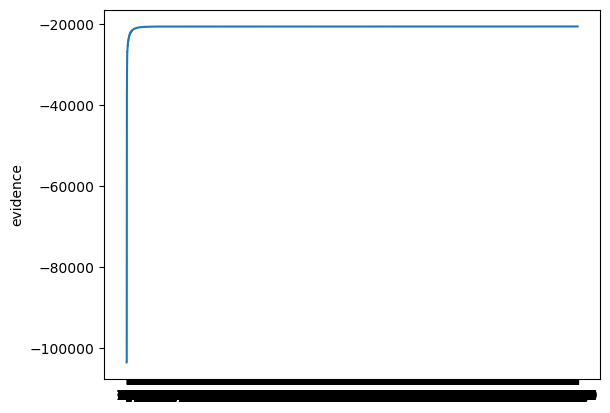

In [59]:
m = 1000
n = 10
d = 3

max_iters = 1000
true_sigma = 0.9
X, Z_true, W_true = generate(m, n , d, true_sigma) 

d = n 
alphas, mu, sigma, W_mu, W_sigma, evidences = VarEM(X, m, n, d, max_iters= max_iters)


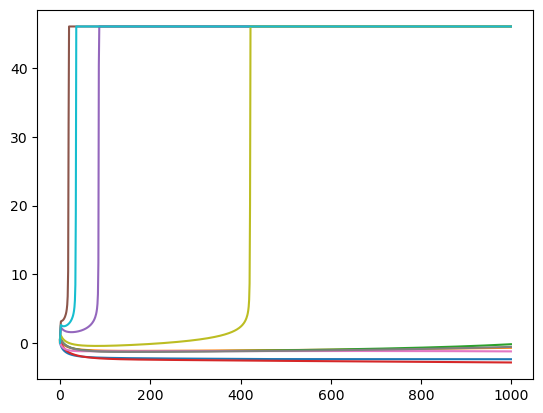

In [60]:
alpha_ = np.stack(alphas, axis = 0)
alpha_[alpha_ > 1e20] = 1e20
alpha_.shape
for i in range(d):
    plt.plot(np.log(alpha_[:, i]))
    
plt.show()

In [61]:
alphas[-1]

array([0.09656302, 0.50911394, 0.85424975, 0.06006418,        inf,
              inf, 0.30131571, 0.57809838,        inf,        inf])

видим, что происходит отбор параметров, однако алгоритм не смог отобрать только два параметра.
